In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import files
#load the dataset
uploaded = files.upload()

Saving Covid-19 Death Cases in Jakarta.csv to Covid-19 Death Cases in Jakarta.csv


In [3]:
import pandas as pd
import io
data = pd.read_csv(io.BytesIO(uploaded['Covid-19 Death Cases in Jakarta.csv']), sep=";")
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data

,Tanggal,Meninggal
0,2020-01-03,0
1,2020-02-03,0
2,2020-03-03,1
3,2020-04-03,0
4,2020-05-03,2
...,...,...
759,2022-03-30,11
760,2022-03-31,8
761,2022-01-04,8
762,2022-02-04,8


Text(0, 0.5, 'Death Cases')

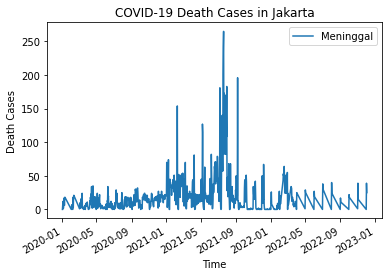

In [4]:
import matplotlib.pyplot as plt
data.plot(x ='Tanggal', y='Meninggal')
plt.title('COVID-19 Death Cases in Jakarta')
plt.xlabel('Time')
plt.ylabel('Death Cases')

In [5]:
# normalize the dataset
dataset=data['Meninggal'].values
dataset=dataset.astype('float32')
dataset=numpy.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train_size)
print(test_size)

611
153


In [7]:
#Create Dataset Function
def create_dataset(dataset,look_back):
  X,Y=[],[]
  for i in range (len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    X.append(a)
    Y.append(dataset[i+look_back,0])
  return numpy.array(X),numpy.array(Y)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

learning_rate=0.01
batch_size=100
neuron_unit=10

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(neuron_unit, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1,activation='tanh',kernel_initializer='glorot_uniform',bias_initializer='zero',use_bias=True))
opt=keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=opt)
history=model.fit(trainX, trainY, epochs=100, batch_size=batch_size, validation_data=(testX,testY),
          callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=2, shuffle=False)
model.reset_states()
model.summary()

# make predictions
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
7/7 - 3s - loss: 0.0129 - val_loss: 0.0088 - 3s/epoch - 425ms/step
Epoch 2/100
7/7 - 0s - loss: 0.0136 - val_loss: 0.0050 - 61ms/epoch - 9ms/step
Epoch 3/100
7/7 - 0s - loss: 0.0124 - val_loss: 0.0030 - 46ms/epoch - 7ms/step
Epoch 4/100
7/7 - 0s - loss: 0.0112 - val_loss: 0.0029 - 47ms/epoch - 7ms/step
Epoch 5/100
7/7 - 0s - loss: 0.0098 - val_loss: 0.0034 - 45ms/epoch - 6ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0090 - val_loss: 0.0031 - 47ms/epoch - 7ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0084 - val_loss: 0.0023 - 47ms/epoch - 7ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0076 - val_loss: 0.0019 - 56ms/epoch - 8ms/step
Epoch 9/100
7/7 - 0s - loss: 0.0068 - val_loss: 0.0017 - 41ms/epoch - 6ms/step
Epoch 10/100
7/7 - 0s - loss: 0.0062 - val_loss: 0.0014 - 41ms/epoch - 6ms/step
Epoch 11/100
7/7 - 0s - loss: 0.0057 - val_loss: 0.0011 - 45ms/epoch - 6ms/step
Epoch 12/100
7/7 - 0s - loss: 0.0054 - val_loss: 9.0494e-04 - 43ms/epoch - 6ms/step
Epoch 13/100
7/7 - 0s - loss: 0.0052 - val_lo

In [8]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [9]:
print(testY.shape)

(1, 151)


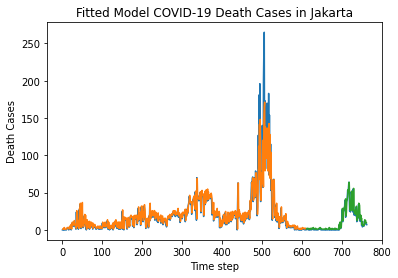

In [10]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Fitted Model COVID-19 Death Cases in Jakarta')
plt.xlabel('Time step')
plt.ylabel('Death Cases')
plt.show()

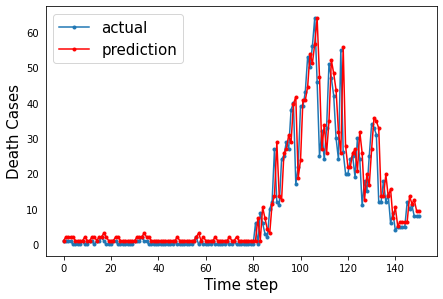

In [11]:
#Plot Prediction
aa=[x for x in range(151)]
plt.figure(figsize=(6,4))
plt.plot(aa,testY[0][:151],marker='.',label="actual")
plt.plot(aa,testPredict[:,0][:151],'r',marker='.',label="prediction")
plt.tick_params(left=False,labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Death Cases',size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

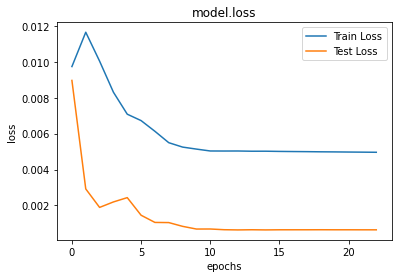

In [ ]:
#Plot loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('model.loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
X_FUTURE = 7
predictions = numpy.array([])
last = testX[-1]
for i in range(X_FUTURE):
  curr_prediction = model.predict(numpy.array([last]))
  last = numpy.concatenate([last[1:], curr_prediction])
  predictions = numpy.concatenate([predictions, curr_prediction[0]])
predictions = scaler.inverse_transform([predictions])[0]
print(predictions)

[10.00136826 11.85282596 13.56684344 15.15447242 16.62558985 17.98909339
 19.25304157]


In [ ]:
#RSQUARE
from sklearn.metrics import r2_score
r2 = r2_score(testY[0][:151],testPredict[:,0][:151])
print(r2)

0.807326609577828


In [ ]:
from sklearn.metrics import mean_absolute_error as mae

# calculate MAE
error = mae(testY[0][:151],testPredict[:,0][:151])
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 4.607580191252247


In [ ]:
#RMSE
#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
rmse = sqrt(mean_squared_error(testY[0][:151],testPredict[:,0][:151]))
print(rmse)

6.713192167757084
